In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
# from torchviz import make_dot

from cifar10_models_qinacme import model1, model3, model2, model_torch_official
%load_ext autoreload
%autoreload 2

In [2]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=False, transform=transform)
# originally: batchsize = 4, shuffle=False
# TODO: increase number of workers/batchsize = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10('/datasets/CIFAR-10', train=False,
                                        download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [21]:
NUM_INCREASE = 3
def train(model, epoch_num = 30):
    results = []
    model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print_freq = 60
    for epoch in range(epoch_num):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
        r = collect_data(model, criterion)
        print('[Epoch {:<2}]: \ntrain_acc  {} \ntrain_loss {} \ntest_acc    {} \ntest_loss  {}'
              .format(epoch, *r))
        results.append(r)
        test_loss = np.array(results)[:,3]
        if epoch > NUM_INCREASE and np.all(np.diff(test_loss[epoch - NUM_INCREASE + 1 : epoch + 1]) > 0):
            print('Early stop at Epoch {}'.format(epoch+1))
            break
    print('Finished Training')
    return results

In [4]:
def collect_data(model, criterion):
    result = []
    for loader in [trainloader,testloader]:
        correct = 0
        total = 0
        loss = 0.
        for data in loader:
            images, labels = data
            outputs = model(Variable(images.cuda()))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum()
            loss += criterion(outputs, Variable(labels.cuda())).data[0]
        result.append(correct / total) # accuracy
        result.append(loss / total) # loss
    return result

In [5]:
def test(model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        
    print('Accuracy of the network on the 10000 test images: {:0.2f}%'
          .format(100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data in testloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels.cuda())
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of {:<5} : {:0.2f}%'
              .format(classes[i], 100*class_correct[i]/class_total[i]))
    

In [6]:
def visualize(model, results):
    results = np.array(results)
    for i in [0,2]:
        plt.plot(np.arange(results.shape[0]), results[:,i])
    plt.legend(['train acc', 'test acc'], loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy - Epoch')
    plt.show()
    for i in [1,3]:
        plt.plot(np.arange(results.shape[0]), results[:,i])
    plt.legend(['train loss', 'test loss'], loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss - Epoch')
    plt.show()

# Original PyTorch tutorial model

In [7]:
net = model_torch_official()

In [8]:
results = train(net)

[Epoch 0 ]: 
train_acc  0.45724 
train_loss 0.011677191307544708 
test_acc    0.4445 
test_loss  0.011869243824481963
[Epoch 1 ]: 
train_acc  0.51476 
train_loss 0.010472458262443543 
test_acc    0.5077 
test_loss  0.010714679384231568
[Epoch 2 ]: 
train_acc  0.55344 
train_loss 0.009767817497253419 
test_acc    0.5354 
test_loss  0.010123423582315445
[Epoch 3 ]: 
train_acc  0.57656 
train_loss 0.009279434888362885 
test_acc    0.5546 
test_loss  0.009746464264392853
[Epoch 4 ]: 
train_acc  0.60924 
train_loss 0.008644008347988128 
test_acc    0.5842 
test_loss  0.009282259345054627
[Epoch 5 ]: 
train_acc  0.6039 
train_loss 0.008700189346075058 
test_acc    0.5679 
test_loss  0.009459574413299561
[Epoch 6 ]: 
train_acc  0.63156 
train_loss 0.008042213574647903 
test_acc    0.6041 
test_loss  0.00890773897767067
[Epoch 7 ]: 
train_acc  0.63878 
train_loss 0.007956619207859039 
test_acc    0.5947 
test_loss  0.009040053963661194
[Epoch 8 ]: 
train_acc  0.66138 
train_loss 0.007488801885

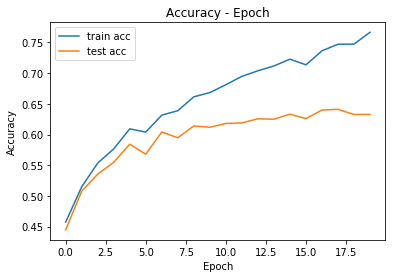

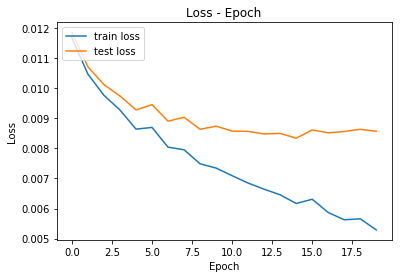

In [9]:
visualize(net, results)

In [10]:
test(net)

Accuracy of the network on the 10000 test images: 63.27%
Accuracy of plane : 65.30%
Accuracy of car   : 70.50%
Accuracy of bird  : 56.20%
Accuracy of cat   : 50.40%
Accuracy of deer  : 53.80%
Accuracy of dog   : 49.70%
Accuracy of frog  : 70.30%
Accuracy of horse : 65.20%
Accuracy of ship  : 81.00%
Accuracy of truck : 70.30%


# Model1

In [15]:
net = model1()

In [16]:
results = train(net)

[Epoch 0 ]: 
train_acc  0.538 
train_loss 0.01503510864019394 
test_acc    0.5366 
test_loss  0.015237543034553528
[Epoch 1 ]: 
train_acc  0.65954 
train_loss 0.014086181373596192 
test_acc    0.6472 
test_loss  0.014341167426109315
[Epoch 2 ]: 
train_acc  0.7082 
train_loss 0.013708619086742401 
test_acc    0.6866 
test_loss  0.014006969571113586
[Epoch 3 ]: 
train_acc  0.72048 
train_loss 0.013607131268978119 
test_acc    0.6997 
test_loss  0.013908497512340546
[Epoch 4 ]: 
train_acc  0.75894 
train_loss 0.01330917763710022 
test_acc    0.7367 
test_loss  0.013624366521835327
[Epoch 5 ]: 
train_acc  0.7889 
train_loss 0.013078424534797668 
test_acc    0.756 
test_loss  0.013466798985004426
[Epoch 6 ]: 
train_acc  0.8061 
train_loss 0.012946880185604095 
test_acc    0.7693 
test_loss  0.013370933306217194
[Epoch 7 ]: 
train_acc  0.80508 
train_loss 0.012945129735469818 
test_acc    0.7686 
test_loss  0.013357244515419007
[Epoch 8 ]: 
train_acc  0.83224 
train_loss 0.012737533140182495

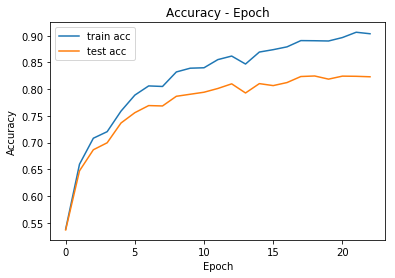

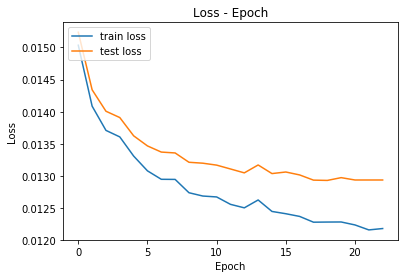

In [17]:
visualize(net, results)

In [18]:
test(net)

Accuracy of the network on the 10000 test images: 82.32%
Accuracy of plane : 81.00%
Accuracy of car   : 90.00%
Accuracy of bird  : 70.80%
Accuracy of cat   : 65.20%
Accuracy of deer  : 81.00%
Accuracy of dog   : 79.90%
Accuracy of frog  : 89.90%
Accuracy of horse : 84.20%
Accuracy of ship  : 89.70%
Accuracy of truck : 91.50%


# Model2

In [23]:
net = model2()

In [24]:
results = train(net)
np.save('report_data/model2_result.npy', results)

[Epoch 0 ]: 
train_acc  0.6217 
train_loss 0.014485504822731018 
test_acc    0.6119 
test_loss  0.014712608468532562
[Epoch 1 ]: 
train_acc  0.68274 
train_loss 0.013964880983829498 
test_acc    0.6541 
test_loss  0.01431124918460846
[Epoch 2 ]: 
train_acc  0.7302 
train_loss 0.01357881856918335 
test_acc    0.6931 
test_loss  0.013996562933921814
[Epoch 3 ]: 
train_acc  0.76062 
train_loss 0.01333178454399109 
test_acc    0.7166 
test_loss  0.013810485768318176
[Epoch 4 ]: 
train_acc  0.7893 
train_loss 0.013095243802070618 
test_acc    0.7328 
test_loss  0.013665910840034485
[Epoch 5 ]: 
train_acc  0.806 
train_loss 0.012971571502685547 
test_acc    0.7335 
test_loss  0.013640155863761902
[Epoch 6 ]: 
train_acc  0.82724 
train_loss 0.012806750574111939 
test_acc    0.7521 
test_loss  0.013524633038043975
[Epoch 7 ]: 
train_acc  0.83968 
train_loss 0.01270074493408203 
test_acc    0.757 
test_loss  0.013465887534618378
[Epoch 8 ]: 
train_acc  0.85632 
train_loss 0.012569663729667663 


In [ ]:
visualize(net, results)

In [ ]:
test(net)

# Model3

In [ ]:
net = model3()

In [ ]:
results = train(net)
np.save('report_data/model3_result.npy', results)

In [ ]:
visualize(net, results)

In [ ]:
test(net)

In [ ]:
# enclosed as an function

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))